# YOLOv8 기반 Fall Detection Pose 순차 학습 실습
이 노트북은 Jupyter Notebook의 순차 실행 방식을 활용하여, 데이터 준비부터 모델 학습, 평가까지 단계별로 실습합니다.

---

**목표:**
- Fall Detection(낙상 감지) Pose 데이터셋을 활용한 YOLOv8 기반 포즈 추정 모델 학습
- 데이터 구조 확인, 라벨 확인, 모델 학습, 예측 및 결과 시각화까지 전체 파이프라인 경험

## 1. 필수 라이브러리 임포트
YOLOv8 학습 및 데이터 처리를 위한 필수 라이브러리를 임포트합니다.
- os: 파일 및 디렉토리 관리
- pandas, numpy: 데이터 처리 및 수치 연산
- ultralytics: YOLOv8 모델 사용
- matplotlib: 이미지 시각화

In [1]:
# 필수 라이브러리 임포트
import os  # 파일 및 디렉토리 관리
import pandas as pd  # 데이터프레임 처리
import numpy as np  # 수치 연산
from ultralytics import YOLO  # YOLOv8 모델 사용
import matplotlib.pyplot as plt  # 시각화 라이브러리
# 위 라이브러리들은 데이터 탐색, 모델 학습, 결과 시각화에 모두 필요합니다.

## 2. 데이터셋 준비 및 확인
Kaggle에서 받은 Fall Detection Pose YOLOv8 데이터셋의 구조를 확인하고, 일부 샘플 이미지를 시각화합니다.
- 데이터셋 폴더 구조를 파악하여, 학습/검증/테스트 데이터의 위치를 확인합니다.
- 테스트 이미지 샘플을 시각화하여 데이터의 형태를 이해합니다.

디렉토리 구조:
../data/Fall Detection Pose YOLOv8 4 files


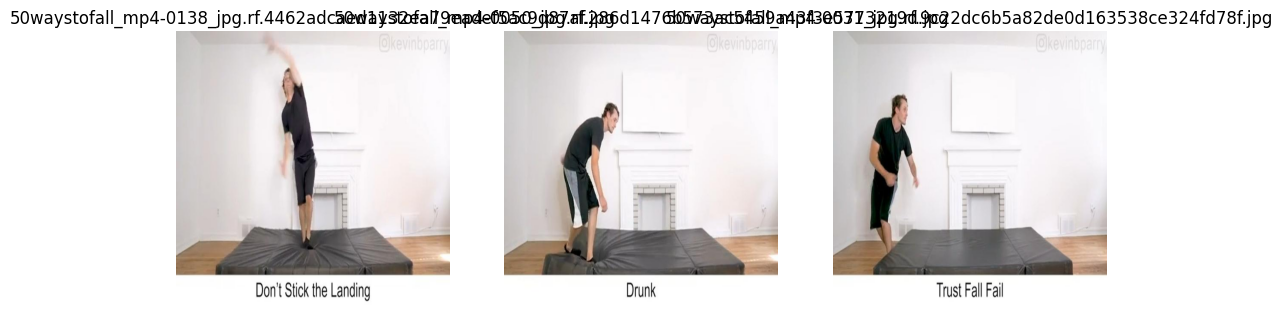

In [2]:
# 데이터셋 경로 지정 및 파일 구조 확인
base_dir = '../data/Fall Detection Pose YOLOv8'  # 데이터셋의 루트 디렉토리 경로
print('디렉토리 구조:')
for root, dirs, files in os.walk(base_dir):
    print(root, len(files), 'files')  # 각 디렉토리별 파일 개수 출력
    break  # 최상위 디렉토리만 출력

# 예시 이미지 시각화
# 테스트 이미지 디렉토리에서 jpg 파일 목록을 가져옴
from PIL import Image

test_img_dir = os.path.join(base_dir, 'test/images')
img_files = [f for f in os.listdir(test_img_dir) if f.endswith('.jpg')]
plt.figure(figsize=(12, 4))
for i, img_name in enumerate(img_files[:3]):  # 앞의 3개 이미지만 시각화
    img_path = os.path.join(test_img_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.show()
# 위 코드는 데이터셋의 구조를 확인하고, 테스트 이미지 샘플을 시각화합니다.

## 3. 순차 실행의 예: 데이터 전처리
YOLOv8 학습을 위한 데이터셋 구조와 라벨 파일을 확인합니다.
- data.yaml: 데이터셋의 클래스, 경로 등 설정 정보
- 라벨 텍스트 파일: 각 이미지에 대한 객체(포즈) 정보가 저장됨

In [3]:
# 라벨 파일 예시 확인 및 데이터 구조 파악
yaml_path = os.path.join(base_dir, 'data.yaml')  # 데이터셋 설정 파일 경로
with open(yaml_path, 'r') as f:
    print(f.read())  # 데이터셋 yaml 파일 내용 출력

# 라벨 텍스트 파일 예시 출력
label_dir = os.path.join(base_dir, 'train/labels')  # 라벨 파일 디렉토리
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
with open(os.path.join(label_dir, label_files[0]), 'r') as f:
    print(f'라벨 파일({label_files[0]}) 내용:')
    print(f.read())
# 위 코드는 데이터셋의 yaml 설정과 라벨 파일의 실제 내용을 확인합니다.

train: ../train/images
val: ../valid/images
test: ../test/images

kpt_shape: [11, 3]
flip_idx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

nc: 2
names: ['Fall-Down', 'Normal']

roboflow:
  workspace: it-vn9yf
  project: fall-detection-n0i4q
  version: 4
  license: CC BY 4.0
  url: https://universe.roboflow.com/it-vn9yf/fall-detection-n0i4q/dataset/4
라벨 파일(50waystofall_mp4-0144_jpg.rf.c39070f9898005d2b7672b9e39365799.txt) 내용:
1 0.4265625 0.6265625 0.31875 0.5171875 0.486328125 0.7569444444444444 2 0.4970703125 0.7013888888888888 2 0.431640625 0.6597222222222221 2 0.5166015625 0.6440972222222221 2 0.5439453125 0.7569444444444444 2 0.3837890625 0.5885416666666666 2 0.3076171875 0.734375 2 0.4111328125 0.44791666666666663 2 0.326171875 0.5052083333333333 2 0.44140625 0.3975694444444444 2 0.32421875 0.845486111111111 2


## 4. 순차 실행의 예: 모델 학습
YOLOv8 모델을 불러와서, 준비한 데이터셋으로 학습을 진행합니다.
- 사전학습된 pose 모델(yolov8n-pose.pt) 사용
- 실습에서는 빠른 실행을 위해 epoch, batch, imgsz를 작게 설정

In [4]:
# YOLOv8 모델 불러오기 및 학습
# (자원이 제한된 환경에서는 epochs를 5 정도로 설정)
model = YOLO('yolov8n-pose.pt')  # 사전학습된 pose 모델 사용
results = model.train(
    data=yaml_path,  # 데이터셋 yaml 경로
    epochs=5,       # 학습 epoch 수 (적절히 조절)
    imgsz=320,      # 입력 이미지 크기 (예시)
    batch=2,        # 배치 크기 (예시)
    project='runs/train',  # 결과 저장 폴더
    name='fall_pose_yolov8_demo',  # 실험 이름
    exist_ok=True,  # 폴더가 이미 있으면 덮어쓰기
    device='cpu'    # CPU 사용 (GPU 사용 시 'cuda')
)
print('학습 완료!')
# 위 코드는 YOLOv8 모델을 불러와서, 지정한 데이터셋으로 학습을 수행합니다.

Ultralytics 8.3.240 🚀 Python-3.12.3 torch-2.9.1+cu128 CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/Fall Detection Pose YOLOv8/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fall_pose_yolov8_demo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

In [5]:
# 학습 결과 요약 자동 출력 (CSV에서 마지막 epoch 결과)
import pandas as pd
import os

# 결과 CSV 파일 경로
result_csv = os.path.join('runs/train/fall_pose_yolov8_demo', 'results.csv')
if os.path.exists(result_csv):
    df = pd.read_csv(result_csv)
    last = df.iloc[-1]
    print(f"[최종 Epoch: {int(last['epoch'])}] mAP50(B): {last['metrics/mAP50(B)']:.4f}, mAP50-95(B): {last['metrics/mAP50-95(B)']:.4f}")
    print(f"Precision(B): {last['metrics/precision(B)']:.4f}, Recall(B): {last['metrics/recall(B)']:.4f}")
    print(f"mAP50(P): {last['metrics/mAP50(P)']:.4f}, mAP50-95(P): {last['metrics/mAP50-95(P)']:.4f}")
    print(f"val/box_loss: {last['val/box_loss']:.4f}, val/pose_loss: {last['val/pose_loss']:.4f}")
else:
    print('결과 CSV 파일이 존재하지 않습니다.')
# 위 코드는 학습이 끝난 후, 주요 성능 지표를 자동으로 출력합니다.

[최종 Epoch: 5] mAP50(B): 0.8969, mAP50-95(B): 0.5338
Precision(B): 0.8223, Recall(B): 0.8397
mAP50(P): 0.0000, mAP50-95(P): 0.0000
val/box_loss: 1.4345, val/pose_loss: 8.4292


## 5. 순차 실행의 예: 예측 및 평가
학습된 모델로 테스트셋 이미지를 예측하고, 결과를 시각화합니다.
- 예측 결과를 이미지로 확인하여 모델의 성능을 직관적으로 평가

In [6]:
# 테스트셋에서 예시 이미지 예측 및 시각화
sample_img = os.path.join(test_img_dir, img_files[0])  # 테스트 이미지 중 첫 번째 파일
results = model.predict(sample_img, save=False, imgsz=640, conf=0.25)  # 예측 수행

# 결과 시각화
from ultralytics.utils.plotting import plot_results
if hasattr(results[0], 'plot'):
    results[0].plot()  # 예측 결과 시각화
else:
    print('결과 시각화 기능은 ultralytics 버전에 따라 다를 수 있습니다.')
# 위 코드는 학습된 모델로 테스트 이미지에 대해 예측을 수행하고, 결과를 시각화합니다.


image 1/1 /home/clyde/dev_ws/deeplearning-repo-2/src/../data/Fall Detection Pose YOLOv8/test/images/50waystofall_mp4-0138_jpg.rf.4462adcaed1132ea79eadef5ac9d87af.jpg: 640x640 (no detections), 138.8ms
Speed: 1.6ms preprocess, 138.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


## 6. 순차 실행의 장점 실습: 단계별 결과 확인
각 셀을 순차적으로 실행하며, 데이터 준비, 전처리, 학습, 예측 결과를 직접 확인해보세요.

- 각 단계별로 출력 결과를 확인하며, 실습 효과를 높일 수 있습니다.
- 오류가 발생하면 해당 셀만 수정 후 재실행할 수 있습니다.

In [7]:
# 학습 결과 요약 출력
print(results)
# 위 코드는 예측 결과 객체의 요약 정보를 출력합니다. (자세한 결과는 객체의 속성 참조)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: ultralytics.engine.results.Keypoints object
masks: None
names: {0: 'Fall-Down', 1: 'Normal'}
obb: None
orig_img: array([[[188, 190, 191],
        [188, 190, 191],
        [188, 190, 191],
        ...,
        [246, 245, 247],
        [246, 245, 247],
        [246, 245, 247]],

       [[188, 190, 191],
        [188, 190, 191],
        [188, 190, 191],
        ...,
        [246, 245, 247],
        [246, 245, 247],
        [246, 245, 247]],

       [[188, 190, 191],
        [188, 190, 191],
        [188, 190, 191],
        ...,
        [246, 245, 247],
        [246, 245, 247],
        [246, 245, 247]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
       